<a href="https://colab.research.google.com/github/pratayyy/MindWise/blob/main/mindwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import time
import cv2
import gym
import random
from gym import spaces
from google.colab import widgets
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
from enum import Enum

MAX_TIMESTEPS = 300
GAMMA = 0.99
ALPHA = 0.3
EPSILON = 1.0
EPISODES = 1000

class Environment(Enum):
  Deterministic = 1
  Stochastic = 2

class Agent(Enum):
  QLearning = 1  
  DoubleQLearning = 2


In [ ]:
from dataclasses import dataclass
@dataclass
class LearningParameter:
  # Default values of learning parameters
    epsilon: float = EPSILON 
    gamma: float = GAMMA
    alpha: float = ALPHA
    max_timesteps: int = MAX_TIMESTEPS
    episodes: int = EPISODES
    epsilon_decay:float = 0.99
@dataclass
class Experience:
    state: int = None 
    action: int = None
    next_state: int = None
    reward: float = None   
    done: bool = None   

In [ ]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    ROWS = 9
    COLS = 9


    NO_OF_ACTIONS = 8

    def remove_points(self,arr:np.ndarray, points:list):
          arr_list = list(arr)
          for i in range(len(points)):
             for j in range(len(arr)):
               if(all(list(arr[j]) == points[i])):
                 arr_list.pop(j)
          return np.asarray(arr_list)
  

    def set_artifact_positions(self,environment:Environment):
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([8, 8])
        self.demon_pos = np.asarray([4, 4])
        stochastic_toxin_pos = [[[3,2], [7,6], [2,7]],[[4,3],[8,5],[3,6]]] 
        stochastic_hp_pos = [[[4,2], [8,6], [3,7]],[[3,3],[8,4],[3,5]]]


        if(environment == Environment.Deterministic ):
          self.toxin_pos = np.asarray([[3,2], [7,6], [2,7]])
          self.hp_pos = np.asarray([[1,1], [3,4], [4,7]])
        else:
          self.toxin_pos = np.asarray(random.choices(stochastic_toxin_pos, weights=(10, 90), k=1)[0])  
          self.hp_pos = np.asarray(random.choices(stochastic_hp_pos, weights=(10, 90), k=1)[0])
       



    def __init__(self, environment_type=Environment.Deterministic, render_trace = False, parameter=LearningParameter()):
        self.environment_type = environment_type
        self.observation_space = spaces.Discrete(self.ROWS * self.COLS)
        self.action_space = spaces.Discrete(self.NO_OF_ACTIONS)
        self.max_timesteps = MAX_TIMESTEPS
        self.timesteps = 0
        self.render_trace = render_trace

        # Create a map of coordinates and state
        self.coordinates_state_mapping = {}
        for i in range(self.ROWS):
            for j in range(self.COLS):
                self.coordinates_state_mapping[f'{np.asarray([j, i])}'] = i * self.COLS + j
                
    def reset(self):
        self.timestep = 0
        self.set_artifact_positions(self.environment_type)

        # return the agent_pos coordinates
        observation = self.coordinates_state_mapping[f'{self.agent_pos}']
        return observation

    def step(self, action):
      
        #Actions
        if action == 0:
          self.agent_pos[0] += 1 # Agent moves right
        elif action == 1:
          self.agent_pos[0] -= 1 # Agent moves left
        elif action == 2:
          self.agent_pos[1] += 1 # Agent moves up
        elif action == 3:
          self.agent_pos[1] -= 1 # Agent moves down
        elif action == 4:        # Agent moves down_right
          self.agent_pos[0] += 1 
          self.agent_pos[1] += 1
        elif action == 5:        # Agent moves top_left
          self.agent_pos[0] -= 1
          self.agent_pos[1] -= 1
        elif action == 6:        # Agent moves top_right
          self.agent_pos[0] += 1
          self.agent_pos[1] -= 1
        elif action == 7:        # Agent moves down_left
          self.agent_pos[0] -= 1  
          self.agent_pos[1] += 1  
            

        # Clipping
        self.agent_pos = np.clip(self.agent_pos, a_min=[0, 0],
                                 a_max=[self.ROWS - 1, self.COLS - 1])
      
        observation = self.coordinates_state_mapping[f'{np.asarray(self.agent_pos)}']
           

        #Reward assignment
        reward = -1
        toxin_reward = -200
        hp_reward = 200
        goal_reward = 2000
        demon_reward = -2000
        
              

        done = False

        # Render is called here to ensure tile-agent interaction visualisation is preserved
        # (Artifacts once popped out of the array will remove the "interaction" for visualisation logic to use)
        if self.render_trace:
          with output_grid.output_to(0, 0):
            output_grid.clear_cell()
            self.render()

       
       # Terminate if goal is attained
        if (self.agent_pos == self.goal_pos).all():
            reward += goal_reward
            done = True

       # Terminate if interacts with demon
        elif(self.agent_pos == self.demon_pos).all():
            reward += demon_reward 
            done = True   
      
        # if hp_pos is encountered, collect reward and pop the hp from hp_pos
        elif any(((hp_pos == self.agent_pos).all() for hp_pos in self.hp_pos)):      
          for i in range(len(self.hp_pos)):
              if (self.agent_pos == self.hp_pos[i]).all():
                reward += hp_reward
                self.hp_pos = self.remove_points(self.hp_pos,[self.hp_pos[i]]) 
                break 
                

        # if toxin_pos is encountered, collect reward and pop the hp from toxin_pos
        elif any(((toxin_pos == self.agent_pos).all() for toxin_pos in self.toxin_pos)):          
          for i in range(len(self.toxin_pos)):
              if (self.agent_pos == self.toxin_pos[i]).all():
                reward += toxin_reward
                self.toxin_pos = self.remove_points(self.toxin_pos,[self.toxin_pos[i]])      
                break

        # Ensure agent is motivated to optimize moves
        else:
          reward-=1        
                  

        self.timestep += 1

        if (self.timestep >= self.max_timesteps):
          done = True

        info = {}
       

        return observation, reward, done, info

    def render(self, mode='human', plot=False):
        """This method renders the environment.

        :param str mode: 'human' renders to the current display or terminal and returns nothing.
        :param bool plot: Boolean indicating whether we show a plot or not. If False, the method returns a resized NumPy
                     array representation of the environment to be used as the state. If True it plots the environment.

        :returns arr preprocessed_image: Grayscale NumPy array representation of the environment."""

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 9)

        if(self.environment_type == Environment.Deterministic):
          ax.set_title('Deterministic Learning Env')
        else:
          ax.set_title('Stochastic Learning Env') 

        def plot_image(plot_pos):
            """This is a helper function to render the environment. It checks which objects are in a particular
            position on the grid and renders the appropriate image.

            :param arr plot_pos: Co-ordinates of the grid position which needs to be rendered."""

            # Initially setting every object to not be plotted.
            plot_agent, plot_hp, plot_goal, plot_toxin, plot_demon = \
                False, False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
            if any(np.array_equal(self.hp_pos[i], plot_pos) for i in range(len(self.hp_pos))):
                plot_hp = True
        
            if any(np.array_equal(self.toxin_pos[i], plot_pos) for i in range(len(self.toxin_pos))):
                plot_toxin = True
       
            if np.array_equal(plot_pos, self.demon_pos):
                plot_demon = True

            if np.array_equal(plot_pos, self.goal_pos):
                plot_goal = True    

            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_hp, plot_goal, plot_toxin, plot_demon]):
                agent = AnnotationBbox(OffsetImage(plt.imread('images/agent.png'), zoom=0.3),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

          
            # Plot for Toxin.
            elif plot_toxin and \
                    all(not item for item in
                        [plot_agent, plot_hp, plot_goal, plot_demon]):
                toxin = AnnotationBbox(OffsetImage(plt.imread('images/toxin.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(toxin)
           
            # Plot for HP.
            elif plot_hp and \
                    all(not item for item in
                        [plot_agent, plot_toxin, plot_goal, plot_demon]):
                hp = AnnotationBbox(OffsetImage(plt.imread('images/hp.png'), zoom=0.3),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(hp)     

            # Plot for Demon.
            elif plot_demon and \
                    all(not item for item in
                        [plot_agent, plot_hp, plot_goal, plot_toxin]):
                demon = AnnotationBbox(OffsetImage(plt.imread('images/demon.png'), zoom=0.3),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(demon)

            # Plot for Goal.
            elif plot_goal and \
                    all(not item for item in
                        [plot_agent, plot_hp, plot_demon, plot_toxin]):
                goal = AnnotationBbox(OffsetImage(plt.imread('images/goal.png'), zoom=0.3),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(goal)    

            # Plot for Agent and HP.
            elif all( [plot_agent, plot_hp]) and \
                    not(all(
                        [plot_goal, plot_toxin, plot_demon])):
                agent_hp = AnnotationBbox(OffsetImage(plt.imread('images/agent_hp.png'), zoom=0.3),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_hp)

            # Plot for Agent and Toxin.
            elif all(item for item in [plot_agent, plot_toxin]) and \
                    all(not item for item in
                        [plot_hp, plot_goal, plot_demon]):
                agent_toxin = AnnotationBbox(OffsetImage(plt.imread('images/agent_toxin.png'), zoom=0.3),
                                           np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_toxin)


            # Plot for Agent and Demon.
            elif all(item for item in [plot_agent, plot_demon]) and \
                    all(not item for item in
                        [plot_goal, plot_toxin, plot_hp]):
                agent_demon = AnnotationBbox(OffsetImage(plt.imread('images/agent_demon.png'),
                                                          zoom=0.3), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_demon)

            # Plot for Agent and Goal.
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_demon, plot_toxin, plot_hp]):
                agent_goal = AnnotationBbox(OffsetImage(plt.imread('images/agent_goal.png'),
                                                          zoom=0.3), np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_goal)    

         
        # Create a map of state and coordinates 
        state_coordinates_mapping = {}
        for j in range(self.ROWS * self.COLS):
            state_coordinates_mapping[j] = np.asarray(
                [j % self.COLS, int(np.floor(j / self.COLS))])

        # Rendering the images for all states.
        for position in state_coordinates_mapping:
            plot_image(state_coordinates_mapping[position])

        plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        plt.yticks([0, 1, 2, 3, 4, 5, 6, 7, 8])
        plt.grid()  # Setting the plot to be of the type 'grid'.

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84 
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image

In [ ]:
class RandomAgent:
  def __init__(self, environment, agent=Agent.QLearning, parameter=LearningParameter()):
    
    self.env = environment
    self.observation_space = environment.observation_space
    self.action_space = environment.action_space

    self.alpha = parameter.alpha
    self.gamma = parameter.gamma
    self.epsilon = parameter.epsilon
    self.max_timesteps = parameter.max_timesteps
    self.episodes = parameter.episodes
    self.epsilon_decay = parameter.epsilon_decay
    self.agent = agent
    if agent == Agent.QLearning:
      self.q_table= np.zeros((self.observation_space.n, self.action_space.n))
    else:
      self.q_table_1= np.zeros((self.observation_space.n, self.action_space.n))
      self.q_table_2= np.zeros((self.observation_space.n, self.action_space.n))



  def q_step(self, state):
    q_state= self.q_table[state]
    exploit= np.argmax(q_state)
    explore= np.random.choice(self.action_space.n)

    # Depending on the epsilon value greedy or random action is chosen
    return explore if random.random() < self.epsilon else exploit

  def double_q_step(self, state):
    q_state_1 = self.q_table_1[state]  
    q_state_2 = self.q_table_2[state]
    exploit = np.argmax(q_state_1 + q_state_2 ) # greedy policy 
    explore= np.random.choice(self.action_space.n)

    return explore if random.random() < self.epsilon else exploit
     

  def use_q_learning(self, experience):
    state, action, next_state, reward, done= experience
    
    # Q-value calculation
    q_next_value= np.zeros([self.action_space.n]) if done else self.q_table[next_state]
    q_value= reward + self.gamma * np.max(q_next_value) - self.q_table[state, action]
    self.q_table[state, action] += self.alpha * q_value


    if done:
      # Setting exponential epsilon decay to prefer exploitation over exploration
      self.epsilon= self.epsilon * self.epsilon_decay


  def use_double_q_learning(self, experience):
    state, action, next_state, reward, done= experience

    useQa = True if random.random() > 0.5 else False # Randomly use either of the tables

    # Q value computation for table 1
    # Qa(s,a) = Qa(s,a) + alpha *[ reward + gamma(Qb(st+1,argmax(Qa(st+1,a`))))]
    q_table_1_next_actions = np.zeros([self.action_space.n]) if done else self.q_table_1[next_state]
    argmax_q_table_1 = np.argmax(q_table_1_next_actions)
    q_target = self.gamma * self.q_table_2[next_state,argmax_q_table_1]
    q_value_1 = reward + self.gamma * q_target - self.q_table_1[state, action]
    self.q_table_1[state, action] += self.alpha * q_value_1


    # Q value computation for table 2
    # Qb(s,a) = Qb(s,a) + alpha *[ reward + gamma(Qa(st+1,argmax(Qb(st+1,a`))))]
    q_table_2_next_actions = np.zeros([self.action_space.n]) if done else self.q_table_2[next_state]
    argmax_q_table_2 = np.argmax(q_table_2_next_actions)
    q_target = self.gamma * self.q_table_2[next_state,argmax_q_table_2]
    q_value_2 = reward + self.gamma * q_target - self.q_table_2[state, action]
    self.q_table_2[state, action] += self.alpha * q_value_2

    if done:
      # Setting exponential epsilon decay to prefer exploitation over exploration
      self.epsilon= self.epsilon * self.epsilon_decay



  def train(self, experience:Experience):
    if self.agent == Agent.QLearning :
      return self.use_q_learning(experience)
    else:
      return self.use_double_q_learning(experience)  
      


  def step(self, observation):
    if self.agent == Agent.QLearning:
      return self.q_step(observation)
    else:
      return self.double_q_step(observation)
    

In [ ]:
from collections import namedtuple

class Simulator:
  def __init__(self, environment:GridEnvironment, agent:Agent = None,parameter=LearningParameter() ):
    
    self.env = environment
    self.agent_type = agent
    self.agent = RandomAgent(environment,agent= Agent.QLearning if self.agent_type == None else self.agent_type,parameter=parameter )

  
  
  def simulate(self, render_graph = False):
    penalty_state  = []
    episode_timestep = []
    epsilon_decay = []
    mean_reward = [] 
    episode_reward = []
    success = []
    succeeded = 0
    failed = 0
    cumulative_reward= 0

  

    for episode in range(self.agent.episodes):
      state= self.env.reset()
      done= False
      reward_per_episode = timestep_per_episode = penalty_states_reached = 0
    

      while not done:
        action= self.agent.step(observation= state)
        next_state, reward, done, info= self.env.step(action= action)
        self.agent.train(experience= (state, action, next_state, reward, done))
        state= next_state

        reward_per_episode += reward
        cumulative_reward += reward
        timestep_per_episode += 1
        if reward < 0:
          penalty_states_reached+=1

      penalty_state.append(penalty_states_reached)
      episode_timestep.append(timestep_per_episode)
      epsilon_decay.append(self.agent.epsilon)
      episode_reward.append(reward_per_episode)
      mean_reward.append(reward_per_episode/self.agent.episodes)
      
      if done == True and self.env.timestep < self.agent.max_timesteps and reward_per_episode: # Positive reward
        # Agent has reached the goal
        succeeded += 1
        success.append(1)
      elif done == True and self.env.timestep == self.agent.max_timesteps:
        # Agent ran out of time & has not reached the goal
        failed += 1
        success.append(0)

    
    if render_graph:
        grid= widgets.Grid(3,2)
        print('Performance of {} agent in \n{} Environment'\
          .format("QLearning" if self.agent_type == Agent.QLearning else "DoubleQLearning",\
                  "Deterministic" if self.env.environment_type == Environment.Deterministic else "Stochastic"))

    # Plot Cumulative Rewards vs Episodes 
        with grid.output_to(0, 0):
          plt.title('Cumulative reward per episode')
          plt.plot(episode_reward)
          plt.xlabel('Episodes')
          plt.ylabel('Reward')  

    # Plot Average Rewards vs Episodes 
        with grid.output_to(0, 1):
          plt.title('Average reward per episode')
          plt.plot(mean_reward)
          plt.xlabel('Episodes')
          plt.ylabel('Reward') 

    # Plot Epsilon Decay vs Episodes 
        with grid.output_to(1, 0):
          plt.title('Epsilon decay')
          plt.plot(epsilon_decay)
          plt.xlabel('Episode')
          plt.ylabel('Epsilon')

    # Plot Episode vs AverageTimesteps
        with grid.output_to(1, 1):
          plt.title('Average Timesteps per episode')
          plt.plot(episode_timestep)
          plt.xlabel('Episode')
          plt.ylabel('Timesteps')  

    # Plot Episode vs AverageBadmoves
        with grid.output_to(2, 0):
         plt.title('Average bad moves per episode')
         plt.plot(penalty_state)
         plt.xlabel('Episode')
         plt.ylabel('Badmoves')     

        with grid.output_to(2, 1):
          y_axis= [np.count_nonzero(i) for i in list(np.array(success).reshape(10,100))]
          fig= plt.figure()
          axis= fig.add_axes([0, 0, 1, 1])
          axis.bar([i for i in range(1, 11)], y_axis, width= 0.25)
          axis.set_title('Success rate by \nagent for every {} episodes'.format(100))
          axis.set_xlabel('Episodes (*100)')
          axis.set_ylabel('Success rate')
          fig.show()

    Metrics = namedtuple ('Metrics',['succeeded','failed','cumulative_reward','penalty_state','episode_timestep','episode_reward','epsilon_decay','mean_reward'])
    return Metrics(succeeded,failed,cumulative_reward,penalty_state,episode_timestep,episode_reward,epsilon_decay,mean_reward)
    

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: ignored

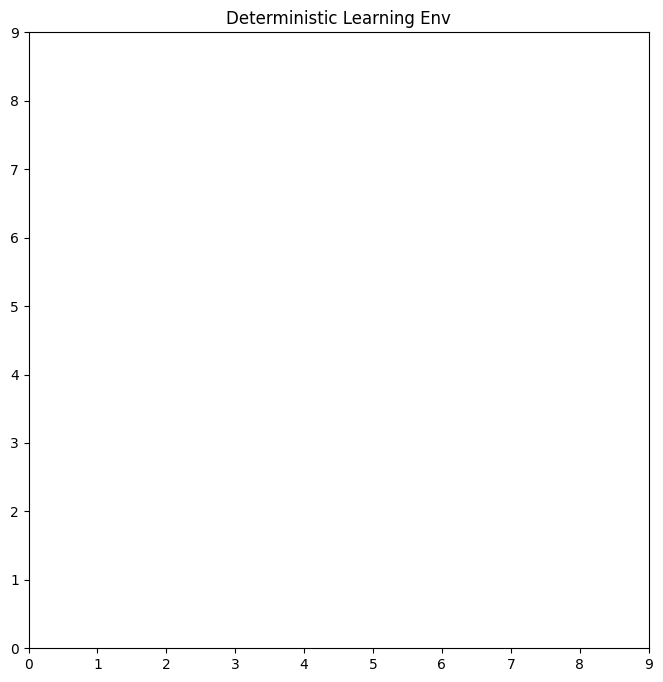

In [ ]:
# Random Agent exploring without learning
env = GridEnvironment(render_trace=True)
agent = RandomAgent(env)

obs = env.reset()
done = False

output_grid = widgets.Grid(1,1)
with output_grid.output_to(0, 0):
  env.render()

while not done:
  action = agent.step(obs)
  obs, reward, done, info = env.step(action)
  time.sleep(0.5)